# Flow statistics - explore

# Global Imports

In [1]:
from collections import defaultdict
from datetime import datetime
import json
import os
import polars as pl
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from GeographyFunctions import FilterGeoDataFrameWithBoundingBox
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt
import numpy as np
from EstimatePenetration import *
from OpenData import *
from SubNetworks import *


## Input Variables

In [2]:
## ------------ SHARED VARIABLES ----------------- ##
# Important Folders
city_pro_dir = os.path.join(os.environ["WORKSPACE"],"city-pro") 
vars_dir = os.path.join(city_pro_dir, "vars")
# Config
dir_config_analysis_day = os.path.join(vars_dir,"config","config_days_bbox.json")
# N classes 
with open(os.path.join(dir_config_analysis_day),"r") as f:
    config_analysis_day = json.load(f)

# Name project-bbox
prefix_files = "bologna_mdt"
name_project_related_to_bbox = config_analysis_day["name_project"]


# Folders
config_dir = os.path.join(city_pro_dir,name_project_related_to_bbox)
fcm_dir = os.path.join(os.environ["WORKSPACE"],"city-pro","output",name_project_related_to_bbox)
PlotDir = os.path.join(fcm_dir, "plots")



# Parameters Days - Classes
StrDates = config_analysis_day["str_dates"]
num_tm = config_analysis_day["num_tm"]
labels = [str(i) for i in range(num_tm + 1)]
Classes = [int(i) for i in range(num_tm + 1)]  # +1 to include the last class

# Variables of Interest
Features = ["time_hours", "lenght_km"]

# 
lon_min,lon_max,lat_min,lat_max = config_analysis_day["lon_min"], config_analysis_day["lon_max"], config_analysis_day["lat_min"], config_analysis_day["lat_max"]

# colors
colors = ['blue', 'yellow', 'green', 'red', 'purple', 'orange', 'pink', 'brown', 'gray', 'cyan']



# Variables .ipynb

In [16]:
fluxes_columns = [f"count_fluxes_{class_}" for class_ in Classes]
colors = ['blue', 'yellow', 'green', 'red', 'purple', 'orange', 'pink', 'brown', 'gray', 'cyan']
fluxes_column_2_color = {fluxes_columns[class_]: colors[class_] for class_ in Classes}
netmob_dir = os.path.join(os.environ["WORKSPACE"],"netmob25","vars",name_project_related_to_bbox,"netmob")
output_netmob_dir = os.path.join(netmob_dir,"vars","output")

## Creates the road files for each class

In [4]:
gdf_road_network = gpd.read_file(os.path.join(PlotDir,"bologna_ceenter_union.geojson"), driver='GeoJSON')
columns_trajs_in_roads = ["user_id","poly_id","timestamp"]
columns_fcm = ["id_act","lenght","time","av_speed","class","origin_lat","origin_lon","destination_lat","destination_lon","start_time","end_time"]


/home/aamad/miniconda3/envs/geostuff/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option DRIVER
  return ogr_read(
/home/aamad/miniconda3/envs/geostuff/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: Several features with id = 1543262 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(


In [5]:
# Initialize count_fluxes to zero if not already
for column in fluxes_columns:
    if column not in gdf_road_network.columns:
        gdf_road_network[column] = 0
is_cycle_1 = True
for Day in tqdm(StrDates):
    # Load Data
    Fcm = pl.read_csv(os.path.join(fcm_dir, f"{prefix_files}_{Day}_{Day}_fcm.csv"), separator=";")
    Trajs_in_roads = pl.read_csv(os.path.join(fcm_dir, f"{prefix_files}_{Day}_{Day}_paths_on_road.csv"), separator=";")

    # Get all users by class
    for class_, Fcm_user in Fcm.groupby("class"):
        user_ids = Fcm_user["id_act"].unique()

        # Filter all relevant trajectories in one go
        trajs_filtered = Trajs_in_roads.filter(pl.col("user_id").is_in(user_ids))
        trajs_filtered.with_columns(pl.col("poly_id").abs())
        # Count visits to each poly_id
        counts = trajs_filtered.group_by("poly_id").len().rename({"len": "count", "poly_id": "poly_lid"})
        # Convert to pandas DataFrame for merging
        counts_df = counts.to_pandas()
        is_cycle_1 = False
        gdf_road_network = gdf_road_network.merge(counts_df, on="poly_lid", how="left")

        gdf_road_network["count"] = gdf_road_network["count"].fillna(0).astype(int)
        gdf_road_network[fluxes_columns[class_]] += gdf_road_network["count"]
        gdf_road_network.drop(columns="count", inplace=True)

  0%|          | 0/8 [00:00<?, ?it/s]

/tmp/ipykernel_392225/3584275853.py:12: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  for class_, Fcm_user in Fcm.groupby("class"):
/tmp/ipykernel_392225/3584275853.py:12: DeprecationWarning: `group_by` iteration will change to always return group identifiers as tuples. Pass `by` as a list to silence this warning, e.g. `group_by(['class'])`.
  for class_, Fcm_user in Fcm.groupby("class"):
 12%|█▎        | 1/8 [00:00<00:01,  5.05it/s]/tmp/ipykernel_392225/3584275853.py:12: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  for class_, Fcm_user in Fcm.groupby("class"):
/tmp/ipykernel_392225/3584275853.py:12: DeprecationWarning: `group_by` iteration will change to always return group identifiers as tuples. Pass `by` as a list to silence this warning, e.g. `group_by(['class'])`.
  for class_, Fcm_user in Fcm.groupby("class"):
 25%|██▌       | 2/8 [00:00<00:00,  6.14it/s]/tmp/ipykernel_392225/3584275853.py:12: DeprecationWar

In [17]:
def update_info_fit(class_2_fit, class_2_distribution, col, A_exp, beta_exp, A_pl, alpha_pl, error_exp, error_pl, R2_exp, R2_pl, bins, y,is_exp):
    if is_exp:
        class_2_fit["class"].append(col)
        class_2_fit["A_exp"].append(A_exp)
        class_2_fit["beta_exp"].append(beta_exp)
        class_2_fit["A_pl"].append(np.nan)
        class_2_fit["alpha_pl"].append(np.nan)
        class_2_fit["error_exp"].append(error_exp)
        class_2_fit["error_pl"].append(np.nan)
        class_2_fit["R2_exp"].append(R2_exp)
        class_2_fit["R2_pl"].append(np.nan)
        class_2_distribution["class"].append(col)
        class_2_distribution["x"].append(bins)
        class_2_distribution["y"].append(y)    
    else:
        class_2_fit["class"].append(col)
        class_2_fit["A_exp"].append(np.nan)
        class_2_fit["beta_exp"].append(np.nan)
        class_2_fit["A_pl"].append(A_pl)
        class_2_fit["alpha_pl"].append(alpha_pl)
        class_2_fit["error_exp"].append(np.nan)
        class_2_fit["error_pl"].append(error_pl)
        class_2_fit["R2_exp"].append(np.nan)
        class_2_fit["R2_pl"].append(R2_pl)
        class_2_distribution["class"].append(col)
        class_2_distribution["x"].append(bins)
        class_2_distribution["y"].append(y)
    return class_2_fit, class_2_distribution


# Distribution Flows

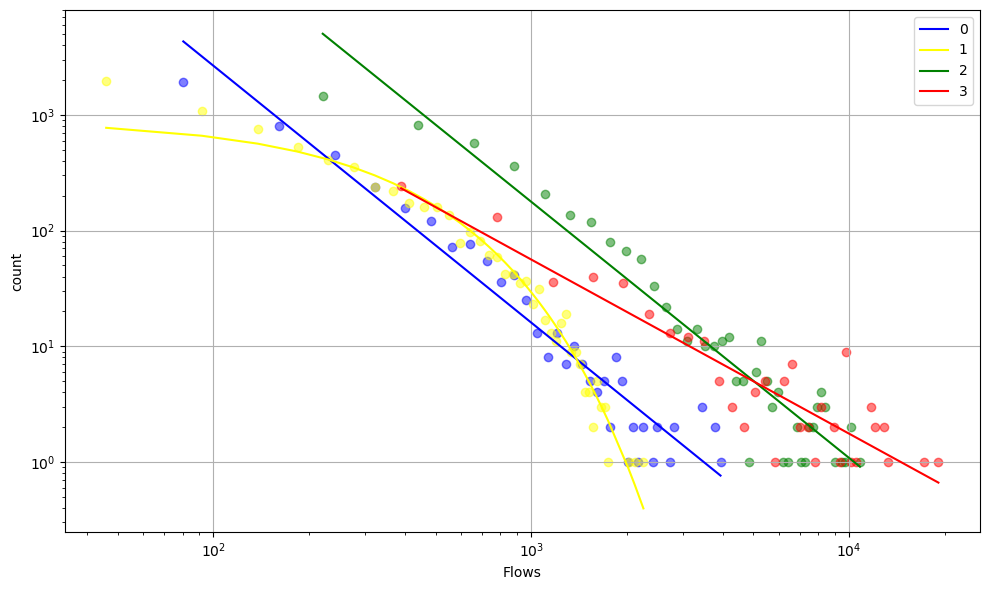

In [ ]:
from FittingProcedures import *
import matplotlib.pyplot as plt
class_2_distribution = {"class":[], "x": [],"y":[]}
class_2_fit = {"class":[], "A_exp": [], "beta_exp": [], "A_pl": [], "alpha_pl": [], "error_exp": [], "error_pl": [], "R2_exp": [], "R2_pl": []}



def plot_label_histograms(df: pd.DataFrame, 
                          fluxes_columns: list,
                          color_dict: dict):
    """
    Plot histograms of the values of 4 labels (columns) in the DataFrame,
    each with its specified color from color_dict.
    """
    plt.figure(figsize=(10, 6))

    for label in fluxes_columns:
        if label in color_dict:
            plt.hist(df[label].dropna(), bins=30, alpha=0.6, label=label, color=color_dict[label])
        else:
            print(f"Warning: No color specified for label '{label}', skipping.")
    
    plt.xlabel("Flows")
    plt.ylabel("Frequency")
    plt.title("Histogram of Labels")
    plt.legend()
#    plt.xscale('log')  # Use logarithmic scale for better visibility
    plt.yscale('log')  # Use logarithmic scale for better visibility
    plt.grid(True)
    plt.tight_layout()
    plt.show()


fig,ax = plt.subplots(1,1,figsize=(10,6))
df_road_flows = pd.DataFrame(gdf_road_network[fluxes_columns].copy())
count = 0
for col in fluxes_columns:
    n,bins = np.histogram(df_road_flows[col],50)
    mask = (bins[:-1] > 0) & (n > 0)  # Ensure bins and counts are positive
    n = n[mask]  # Filter out zero counts
    bins = bins[:-1][mask]  # Adjust bins to match non
    A_exp,beta_exp,exp_,error_exp,R2_exp,A_pl,alpha_pl,pl_,error_pl,R2_pl,bins_plot = compare_exponential_power_law_from_xy(bins,n)
    if error_exp < error_pl:
        y = A_exp * np.exp(beta_exp * bins)
        class_2_fit, class_2_distribution = update_info_fit(class_2_fit, 
                                                            class_2_distribution, 
                                                            col, 
                                                            A_exp, 
                                                            beta_exp, 
                                                            A_pl, 
                                                            alpha_pl, 
                                                            error_exp, 
                                                            error_pl, 
                                                            R2_exp, 
                                                            R2_pl, 
                                                            bins, 
                                                            y,
                                                            True)
    else:
        y = A_pl * (bins ** (alpha_pl))
        class_2_fit, class_2_distribution = update_info_fit(class_2_fit, 
                                                            class_2_distribution, 
                                                            col, 
                                                            A_exp, 
                                                            beta_exp, 
                                                            A_pl, 
                                                            alpha_pl, 
                                                            error_exp, 
                                                            error_pl, 
                                                            R2_exp, 
                                                            R2_pl, 
                                                            bins, 
                                                            y,
                                                            False)
    ax.plot(bins, y, label=Classes[count], color=fluxes_column_2_color[col])
    ax.scatter(bins, n, color=fluxes_column_2_color[col], alpha=0.5)
    count += 1
ax.set_xlabel("Flows")
ax.set_ylabel("count")
ax.set_xscale('log')  # Use logarithmic scale for better visibility
ax.set_yscale('log')  # Use logarithmic scale for better visibility
ax.grid(True)
ax.legend()
plt.tight_layout()
pd.DataFrame(class_2_fit).to_csv(os.path.join(output_netmob_dir,"class_2_fit.csv"), index=False)
pd.DataFrame(class_2_distribution).to_csv(os.path.join(output_netmob_dir,"class_2_distribution.csv"), index=False)
plt.savefig(os.path.join(output_netmob_dir,"class_2_fit.png"), dpi=300)
plt.show()
